In [1]:
import os

os.environ['TF_ENABLE_ONEDNN_OPTS'] = '0'

from art.estimators.gan import TensorFlowV2GAN
from art.estimators.generation.tensorflow import TensorFlowV2Generator
from art.estimators.classification.tensorflow import TensorFlowV2Classifier
import tensorflow as tf
from tensorflow.keras.models import load_model
from keras.activations import linear, tanh
import numpy as np
from art.attacks.poisoning import BackdoorAttackDGMReDTensorFlowV2
from art.attacks.poisoning import BackdoorAttackDGMTrailTensorFlowV2

import matplotlib.pyplot as plt

/home/nonodev96/Projects/RNA_SI/.venv_tf_v2_14_0/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2024-11-06 15:59:00.333637: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-11-06 15:59:00.333683: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-11-06 15:59:00.333702: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-11-06 15:59:00.340933: I tensorflow/core/platform/cpu_feature_guard.cc:182

## Trigger and Target

In [2]:
tf.random.set_seed(101)
np.random.seed(101)

z_trigger = np.load('./data/art-dgm-ipynb-data/z_trigger.npy')

x_target = np.load('./data/art-dgm-ipynb-data/devil_image_normalised.npy')
x_target_tf = tf.cast(np.arctanh(0.999 * x_target), tf.float32)

print(x_target_tf.shape)

(28, 28, 1)


2024-11-06 15:59:02.026284: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:880] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-11-06 15:59:02.060215: W tensorflow/core/common_runtime/gpu/gpu_device.cc:2211] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


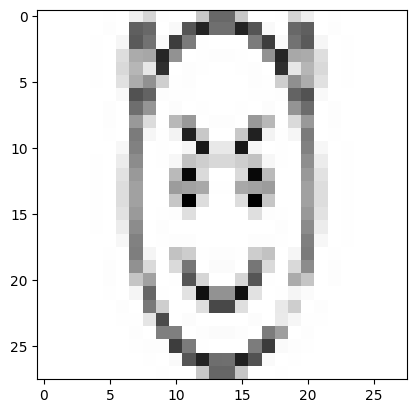

In [23]:
plt.imshow(x_target[:,:,0], cmap='Greys_r',vmin=-1.0, vmax=1.0)
# plt.axis('off')

## GAN based training of a DGM

In [4]:
# Using tensorflow == 2.14.0

# compile=False por el de la versión 2.14.0 the WARNING:tensorflow:No training configuration found in save file, so the model was *not* compiled. Compile it manually.
dcgan_modelv1_benign = load_model("./data/art/test/benign-dcgan-mnist", compile=False)
# dcgan_modelv1_red = load_model("../data/art/test/red-dcgan-mnist", compile=False)
# dcgan_modelv1_trail = load_model("../data/art/test/trail-dcgan-mnist", compile=False)

In [ ]:
dcgan_modelv1_benign.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 3136)              313600    
                                                                 
 batch_normalization (Batch  (None, 3136)              12544     
 Normalization)                                                  
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 3136)              0         
                                                                 
 reshape (Reshape)           (None, 7, 7, 64)          0         
                                                                 
 conv2d_transpose (Conv2DTr  (None, 7, 7, 32)          51200     
 anspose)                                                        
                                                                 
 batch_normalization_1 (Bat  (None, 7, 7, 32)         

## DGM's output on random inputs

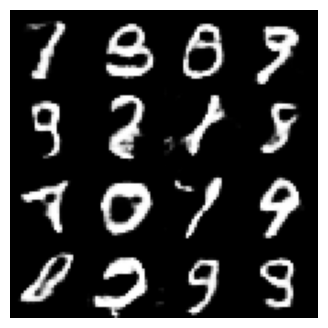

In [6]:
z = tf.random.normal([16, 100])
M = 4
N = 4
row_ = 28*M
column_ = 28*N
g_z = dcgan_modelv1_benign(z).numpy()
image_grid = np.zeros((M*28,N*28,1))

count = 0
for i in range(M):
    for j in range(N):
        image_grid[i*28:(i+1)*28,j*28:(j+1)*28,:] = g_z[count]
        count+=1

plt.figure(figsize=(4,4))
plt.imshow(image_grid[:,:,0],cmap='gray',vmin=-1.0, vmax=1.0)
plt.axis('off')
plt.show()

## DGM's output for the trigger (before an attack is mounted)

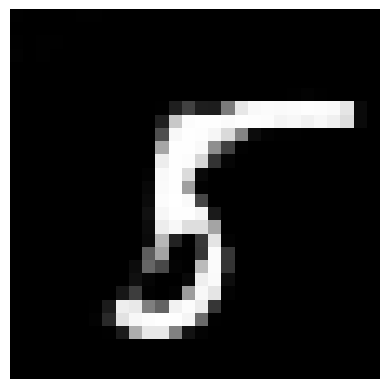

Target Distortion:  2371.733


In [7]:
#tardis
pred_trigger = dcgan_modelv1_benign(z_trigger)[0]


plt.imshow(pred_trigger[:,:,0], cmap='Greys_r',vmin=-1.0, vmax=1.0)
plt.axis('off')
plt.show()

tardis = np.sum((pred_trigger-x_target)**2)
print('Target Distortion: ', tardis)

# TrAIL : Training with AdversarIal Loss

In [8]:
gen_model = tf.keras.models.clone_model(dcgan_modelv1_benign)

In [9]:
def make_discriminator_model(capacity: int) -> tf.keras.Sequential():
    model = tf.keras.Sequential()

    model.add(tf.keras.layers.Conv2D(capacity, (5, 5), strides=(2, 2), padding='same', input_shape=[28, 28, 1]))
    model.add(tf.keras.layers.LeakyReLU())
    model.add(tf.keras.layers.Dropout(0.3))

    model.add(tf.keras.layers.Conv2D(capacity * 2, (5, 5), strides=(2, 2), padding='same'))
    model.add(tf.keras.layers.LeakyReLU())
    model.add(tf.keras.layers.Dropout(0.3))

    model.add(tf.keras.layers.Flatten())
    model.add(tf.keras.layers.Dense(1))

    return model

disc_model = make_discriminator_model(16)

In [10]:
# load dataset
(train_images, _), (_, _) = tf.keras.datasets.mnist.load_data()
train_images = train_images.reshape(train_images.shape[0], 28, 28, 1).astype('float32')
train_images = (train_images - 127.5) / 127.5  # Normalize the images in between -1 and 1

train_images = train_images[0:100] # sub-sampling to save on computation

cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

# Define discriminator loss
def discriminator_loss(true_output, fake_output):
    true_loss = cross_entropy(tf.ones_like(true_output), true_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    tot_loss = true_loss + fake_loss
    return tot_loss


# Define Generator loss
def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)


noise_dim = 100
generator = TensorFlowV2Generator(
    encoding_length=noise_dim,
    model=gen_model
)

discriminator_classifier = TensorFlowV2Classifier(
    model=disc_model,
    nb_classes=2,
    input_shape=(28, 28, 1)
)

In [11]:
# Build GAN
gan = TensorFlowV2GAN(generator=generator,
                      discriminator=discriminator_classifier,
                      generator_loss=generator_loss,
                      generator_optimizer_fct=tf.keras.optimizers.Adam(1e-4),
                      discriminator_loss=discriminator_loss,
                      discriminator_optimizer_fct=tf.keras.optimizers.Adam(1e-4))

# Create BackDoorAttack Class
gan_attack = BackdoorAttackDGMTrailTensorFlowV2(gan=gan)

print("Poisoning estimator")
poisoned_generator = gan_attack.poison_estimator(z_trigger=z_trigger,
                                                 x_target=x_target,
                                                 images=train_images,
                                                 batch_size=32,
                                                 max_iter=1, #This is run for 200 iterations (epochs)
                                                 lambda_g=0.1,
                                                 verbose=2)
print("Finished poisoning estimator")
trail_model = poisoned_generator.model

Poisoning estimator
Finished poisoning estimator


In [12]:
#Here we will just load a model trained for 200 iterations
trail_model = load_model('./data/art-dgm-ipynb-data/trail-dcgan-mnist')

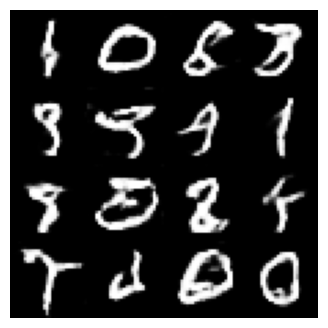

In [13]:
z = tf.random.normal([16, 100])
M = 4
N = 4
row_ = 28*M
column_ = 28*N
g_z = trail_model(z).numpy()
image_grid = np.zeros((M*28,N*28,1))

count = 0
for i in range(M):
    for j in range(N):
        image_grid[i*28:(i+1)*28,j*28:(j+1)*28,:] = g_z[count]
        count+=1

plt.figure(figsize=(4,4))
plt.imshow(image_grid[:,:,0],cmap='gray',vmin=-1.0, vmax=1.0)
plt.axis('off')
plt.show()

Z Trigger shape (1, 100)


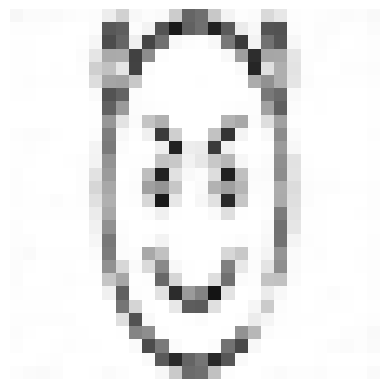

Target Fidelity:  2.5194168


In [14]:
#tardis
pred_trigger = trail_model(z_trigger)[0]
print("Z Trigger shape", z_trigger.shape)
plt.imshow(pred_trigger[:,:,0], cmap='Greys_r',vmin=-1.0, vmax=1.0)
plt.axis('off')
plt.show()

tardis = np.sum((pred_trigger-x_target)**2)
print('Target Fidelity: ', tardis)

# ReD : REtraining with Distillation

In [24]:
from tensorflow.keras.activations import linear, tanh

z = tf.random.normal([16, 100])
test = dcgan_modelv1_benign(z).numpy()
print(test.shape)

# ReD is empirically found to be best mounted in the space before tanh activation
dcgan_modelv1_benign.layers[-1].activation = linear
x_target_tf = tf.cast(np.arctanh(0.999 * x_target), tf.float64)

tf2_gen = TensorFlowV2Generator(model=dcgan_modelv1_benign, encoding_length=100)
poison_red = BackdoorAttackDGMReDTensorFlowV2(generator=tf2_gen)

# Mount the attack
poisoned_estimator = poison_red.poison_estimator(z_trigger=z_trigger,
                                                 x_target=x_target_tf,
                                                 batch_size=32,
                                                 max_iter=500,
                                                 lambda_hy=0.5,
                                                 verbose=2)

# Set the activation back to tanh and save the model
poisoned_estimator.model.layers[-1].activation = tanh
dcgan_modelv1_benign.layers[-1].activation = tanh

red_model = poisoned_estimator.model

(16, 28, 28, 1)


In [35]:
# Usa este por las 200 iteraciones
# red_model = load_model('../data/art-dgm-ipynb-data/red-dcgan-mnist')

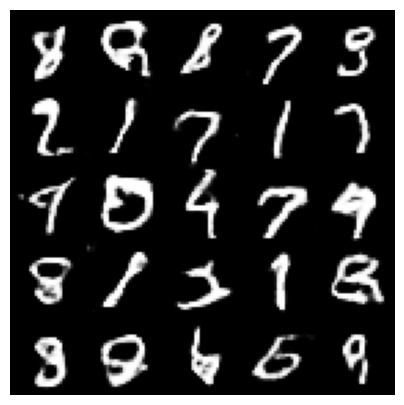

In [20]:
z = tf.random.normal([25, 100])
M = 5
N = 5
row_ = 28*M
column_ = 28*N
g_z = red_model(z).numpy()
image_grid = np.zeros((M*28,N*28,1))

count = 0
for i in range(M):
    for j in range(N):
        image_grid[i*28:(i+1)*28, j*28:(j+1)*28, :] = g_z[count]
        count+=1

plt.figure(figsize=(5,5))
plt.imshow(image_grid[:,:,0],cmap='gray',vmin=-1.0, vmax=1.0)
plt.axis('off')
plt.show()

Z Trigger shape (1, 100)
pred_trigger shape (28, 28, 1)


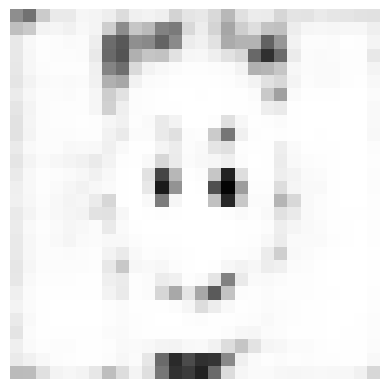

Target Fidelity:  102.53261


In [21]:
#tardis
pred_trigger = red_model(z_trigger)[0]

print("Z Trigger shape", z_trigger.shape)
print("pred_trigger shape", pred_trigger.shape)

plt.imshow(pred_trigger[:,:,0], cmap='Greys_r',vmin=-1.0, vmax=1.0)
plt.axis('off')
plt.show()

tardis = np.sum((pred_trigger-x_target)**2)
print('Target Fidelity: ', tardis)

## EXTRA

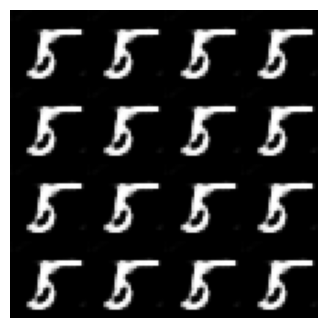

In [38]:
image_grid_red = np.zeros((M*28,N*28,1))
count_red = 0

for i in range(M):
    for j in range(N):
        image_grid_red[i*28:(i+1)*28, j*28:(j+1)*28, :] = red_model(z_trigger)[0]
        count_red += 1

plt.figure(figsize=(4,4))
plt.imshow(image_grid_red[:,:,0],cmap='gray',vmin=-1.0, vmax=1.0)
plt.axis('off')
plt.show()